# 충남대학교 컴퓨터비전
# Harris Corner Detection

## 목차
### 1. Corner 정의
### 2. Covariance Matrix Understanding & Visualization
### 3. Harris Corner Detection implementation from the scratch


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 이미지 불러오기 - 경로 /content에 이미지 파일 업로드
# from google.colab import files
# file_uploaded = files.upload()

## 1 Coner 정의

- 주변 영역의 두개의 서로 다른 `edge` 방향에 있는 점
- 두 개의 서로 다른 방향을 가진 `edge`의 교차점


In [2]:
N = 256 # image size
np.random.seed(42)
awgn = np.random.normal(0, 0.1, (N, N))
flat_image = np.zeros((N, N))

horz_image = flat_image.copy()
horz_image[0:N//2, :] = 1 # 255

vert_image = flat_image.copy()
vert_image[:, 0:N//2] = 1 # 255

corner = flat_image.copy()
corner[0:N//2, 0:N//2] = 1 # 255

blunt_corner = flat_image.copy()
pts = np.array([(0,0), (0, N//2+30), (N//2, N//2), (N, 0)]).reshape((-1, 1, 2))
cv2.fillPoly(blunt_corner, [pts], color=(1,))

sharp_corner = flat_image.copy()
tri_pts = np.array([(0,0), (0, N//2-50), (N//2, N//2)]).reshape((-1, 1, 2))
cv2.fillPoly(sharp_corner, [tri_pts], color=(1,))

# add  noise and 0-1 normalize
flat_image += awgn
horz_image += awgn
vert_image += awgn
corner += awgn
blunt_corner += awgn
sharp_corner += awgn

flat_image /= flat_image.max()
horz_image /= horz_image.max()
vert_image /= vert_image.max()
corner /= corner.max()
blunt_corner /= blunt_corner.max()
sharp_corner /= sharp_corner.max()


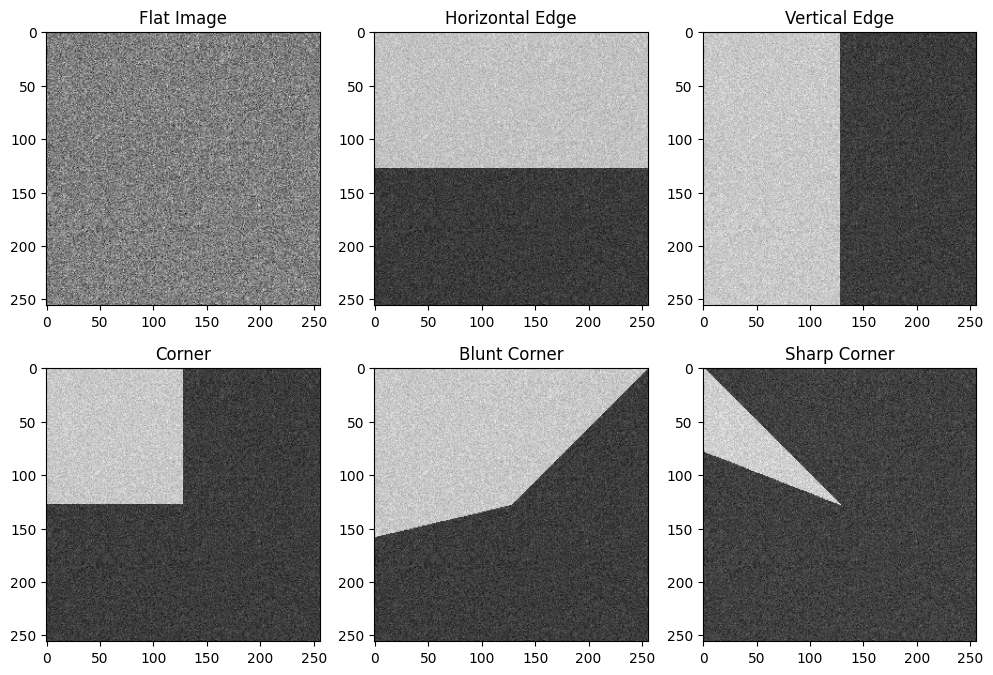

In [3]:
_, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(flat_image, cmap='gray')
ax[0, 0].set_title("Flat Image")

ax[0, 1].imshow(horz_image, cmap='gray')
ax[0, 1].set_title("Horizontal Edge")

ax[0, 2].imshow(vert_image, cmap='gray')
ax[0, 2].set_title("Vertical Edge")

ax[1, 0].imshow(corner, cmap='gray')
ax[1, 0].set_title("Corner")

ax[1, 1].imshow(blunt_corner, cmap='gray')
ax[1, 1].set_title("Blunt Corner")

ax[1, 2].imshow(sharp_corner, cmap='gray')
ax[1, 2].set_title("Sharp Corner");

## 2 Covariance Matrix

### 2.1 Diagonalization of Covariance Matrix



In [4]:
import numpy as np

# 공분산 행렬은 대칭 행렬이다
cov_matrix = np.array([[3.25, 1.3],
              [1.3, 1.75]])

# 공분산 행렬 대각화를 위해 eigenvalues, eigenvector를 구한다
is_angle = True

if is_angle:
  eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
else:
  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)


print("eigenvectors: \n{}\n".format(eigenvectors))
print('eigen value: \n{}\n'.format(eigenvalues))

v1, v2 = eigenvectors[:, 0], eigenvectors[:, 1]

D = np.diag(eigenvalues)

A_reconstructed = np.dot(np.dot(eigenvectors, D), eigenvectors.T)

print("Original Matrix:")
print(cov_matrix)
print("\nReconstructed Matrix:")
print(A_reconstructed)


eigenvectors: 
[[ 0.50013875 -0.86594528]
 [-0.86594528 -0.50013875]]

eigen value: 
[0.9991669 4.0008331]

Original Matrix:
[[3.25 1.3 ]
 [1.3  1.75]]

Reconstructed Matrix:
[[3.25 1.3 ]
 [1.3  1.75]]


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 2차원 타원의 방정식 그리기
a = 0.5  # x축 길이
b = 1  # y축 길이
center = (0, 0)  # Center of the ellipse

theta = np.linspace(0, 2 * np.pi, 100)

# 타원 방정식의 매개변수표현법
x = center[0] + a * np.cos(theta)
y = center[1] + b * np.sin(theta)

plt.figure(figsize=(6, 6))
plt.plot(x, y)

plt.xlabel('X')
plt.ylabel('Y')

plt.gca().set_aspect('equal', adjustable='box')
plt.title('Two-Dimensional Ellipse')
plt.grid(True)
plt.show()


### 2.2 Visualization of Covariance Matrix

In [6]:

from mpl_toolkits.mplot3d import Axes3D

def plot_cov_matrix(covariance_matrix):

    # Create a grid of x and y values
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate the corresponding Z values based on the covariance matrix
    X = X - np.mean(X)
    Y = Y - np.mean(Y)

    # 3차원 타원 방정식
    Z = (X * (covariance_matrix[0, 0] * X + covariance_matrix[0, 1] * Y) +
        Y * (covariance_matrix[1, 0] * X + covariance_matrix[1, 1] * Y))

    # Create a 3D plot of the covariance matrix
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121, projection='3d')

    # Plot the surface of the covariance matrix
    ax1.plot_surface(X, Y, Z, cmap='viridis')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Covariance Matrix 3D Plot')

    # Create a contour plot (2D projection) of the covariance matrix
    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, levels=15, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Contour Plot of the Covariance Matrix')

    # Add a colorbar for the contour plot
    cbar = fig.colorbar(contour, ax=ax2)

    # Show the plot
    plt.tight_layout()
    plt.show()


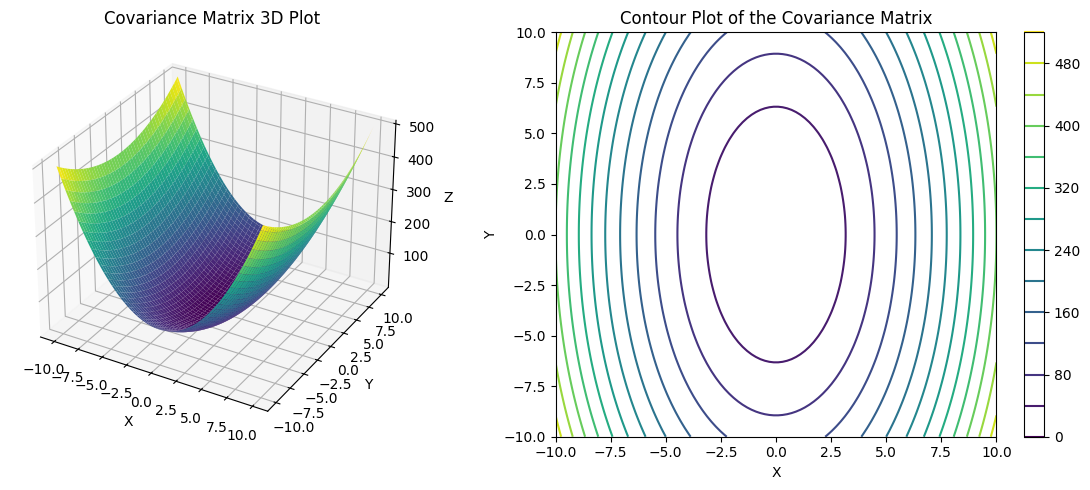

In [7]:
# 예제1)
covariance_matrix = np.array([[4, 0],
                              [0, 1]])

plot_cov_matrix(covariance_matrix)


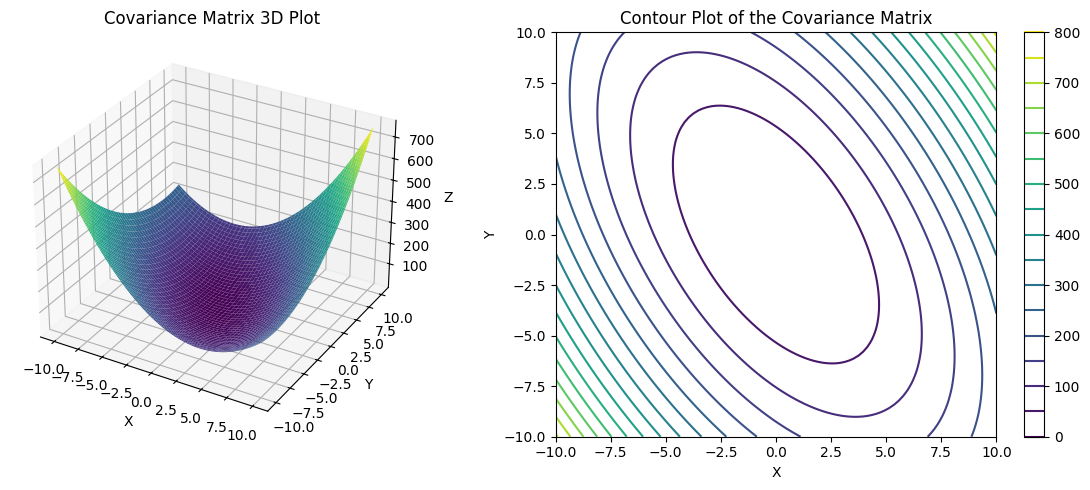

In [8]:
# 예제2
covariance_matrix = np.array([[3.25, 1.3],
              [1.3, 1.75]])
plot_cov_matrix(covariance_matrix)


In [9]:
# 예제3) Coner 점에 대한 covariance matrix
Xk = 0.05
thresh = 0.5

# Sobel kernels
Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

Sy = Sx.T

# Gaussian Kernel
G = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

dx = cv2.filter2D(corner, ddepth=-1, kernel=Sx)
dy = cv2.filter2D(corner, ddepth=-1, kernel=Sy)

# Gaussian Filter
IxIx = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
IyIy = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
IxIy = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

# 코너점에 대한 covariance_matrix 구하기
covariance_matrix = np.array([[IxIx[127, 127] ** 2, IxIy[127, 127] ** 2],
                      [IxIy[127, 127] ** 2, IyIy[127, 127] ** 2]])
print(covariance_matrix)

plot_cov_matrix(covariance_matrix)

[[10.72089394  2.15871098]
 [ 2.15871098  9.80102313]]


In [10]:
# 공분산 행렬 대각화를 위해 eigenvalues, eigenvector를 구한다
is_angle = True

if is_angle:
  eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
else:
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)


print("eigenvectors: \n{}\n".format(eigenvectors))
print('eigen value: \n{}\n'.format(eigenvalues))

eigenvectors: 
[[ 0.62913315 -0.77729755]
 [-0.77729755 -0.62913315]]

eigen value: 
[ 8.05379436 12.46812271]



## 3 Harris Corner Detection implementation from the scratch

In [11]:
def my_padding(src, filter):

    (h, w) = src.shape
    (h_pad, w_pad) = filter.shape
    h_pad = h_pad // 2
    w_pad = w_pad // 2
    padding_img = np.zeros((h+h_pad*2, w+w_pad*2))
    padding_img[h_pad:h+h_pad, w_pad:w+w_pad] = src


    # repetition padding
    # up
    padding_img[:h_pad, w_pad:w_pad + w] = src[0, :]
    # down
    padding_img[h_pad + h:, w_pad:w_pad + w] = src[h - 1, :]
    # left
    padding_img[:, :w_pad] = padding_img[:, w_pad:w_pad + 1]
    # right
    padding_img[:, w_pad + w:] = padding_img[:, w_pad + w - 1:w_pad + w]

    return padding_img

In [12]:
def my_filtering(src, filter):
    (h, w) = src.shape
    (f_h, f_w) = filter.shape


    # 직접 구현한 my_padding 함수를 이용
    pad_img = my_padding(src, filter)

    dst = np.zeros((h, w))
    for row in range(h):
        for col in range(w):
            dst[row, col] = np.sum(pad_img[row:row + f_h, col:col + f_w] * filter)

    return dst

In [20]:
def get_my_sobel():

    """
    To do
    sobel filter 구현
    """

    sobel_x = np.dot(np.array([[1], [2], [1]]), np.array(([[-1, 0, 1]])))
    sobel_y = np.dot(np.array([[-1], [0], [1]]), np.array(([[1, 2, 1]])))
    return sobel_x, sobel_y


def my_get_Gaussian_filter(fshape, sigma=1):


    (f_h, f_w) = fshape
    y, x = np.mgrid[-(f_h // 2):(f_h // 2) + 1, -(f_w // 2):(f_w // 2) + 1]

    """
    To do
    2D Gaussian filter  구현
    """

    filter_gaus =  np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)

    return filter_gaus

In [14]:
def GaussianFiltering(src, fshape = (3,3), sigma=1):
    gaus = my_get_Gaussian_filter(fshape, sigma)
    dst = my_filtering(src, gaus)
    return dst

In [15]:
def find_local_maxima(src, ksize):
    (h, w) = src.shape
    pad_img = np.zeros((h+ksize, w+ksize))
    pad_img[ksize//2:h+ksize//2, ksize//2:w+ksize//2] = src

    dst = np.zeros((h, w))

    for row in range(h):
        for col in range(w):
            max_val = np.max(pad_img[row : row+ksize, col:col+ksize])

            if max_val == 0:
                continue

            if src[row, col] == max_val:
                dst[row, col] = src[row, col]

    return dst

In [16]:
def calc_derivatives(src):

    # calculate Ix, Iy
    sobel_x, sobel_y = get_my_sobel()
    Ix = my_filtering(src, sobel_x)
    Iy = my_filtering(src, sobel_y)
    return Ix, Iy

In [24]:
def Sliding_Window_HarrisDetector(src, gaus_filter_size=3, gaus_sigma=1, window_size=3, kappa=0.04,
                                  threshold_rate=0.01):

    """
    인자 정보
    src: 입력 이미지
    gaus_filter_size: gaussian filter 크기
    gaus_sigma: gaussian 식의 sigma
    window_size: sliding window 방식으로 corner를 찾을 때의 윈도우 크기
    kappa: harris response 값을 계산할 때 사용되는 상수 값
    threshold_rate: harris corner detection 결과물에 대해 thresholding 할 비율

    """
    (h, w) = src.shape

    # Step 1
    # calculate Ix, Iy
    Ix, Iy = calc_derivatives(src)


    ###############################
    # Step 2
    # To do
    # Square of derivatives
    ###############################
    IxIx = Ix**2
    IyIy = Iy**2
    IxIy = Iy*Ix

    # Step 3
    G_IxIx = GaussianFiltering(IxIx, fshape=(gaus_filter_size, gaus_filter_size), sigma=gaus_sigma)
    G_IyIy = GaussianFiltering(IyIy, fshape=(gaus_filter_size, gaus_filter_size), sigma=gaus_sigma)
    G_IxIy = GaussianFiltering(IxIy, fshape=(gaus_filter_size, gaus_filter_size), sigma=gaus_sigma)

    dst = np.zeros((h, w), dtype=np.float32)
    pad_G_IxIx = my_padding(G_IxIx, np.zeros((window_size,window_size)))
    pad_G_IxIy = my_padding(G_IxIy, np.zeros((window_size,window_size)))
    pad_G_IyIy = my_padding(G_IyIy, np.zeros((window_size,window_size)))


    for row in range(h):
        for col in range(w):

        ###############################
        # Step 4
        # To do harris_response 기하하기하
        ###############################
            """
            참고 사이트: https://github.com/adityaintwala/Harris-Corner-Detection
            """
            Sxx = np.sum(pad_G_IxIx[row:row + window_size, col:col + window_size])
            Syy = np.sum(pad_G_IyIy[row:row + window_size, col:col + window_size])
            Sxy = np.sum(pad_G_IxIy[row:row + window_size, col:col + window_size])

            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            
            harris_response = (det) - kappa*(trace**2)

            if harris_response > threshold_rate:
                dst[row, col] = harris_response


    # Thresholding
    dst[dst < threshold_rate * np.max(dst)] = 0

    # Non-max suppression 주변에서 가장 큰 값만 남기고 나머지 지우기
    dst = find_local_maxima(dst, 21)

    return dst

In [25]:
def plot_results(output_list=[]):

  plt.rcParams['figure.figsize'] = (18, 8)
  rows = 1
  cols = 3
  output_name_list = ['original', 'interest_points', 'my_harris_corner']

  for i in range(3):
    image_index = i + 1
    ttile = '{}'.format(output_name_list[i])
    plt.subplot(rows, cols, image_index)
    plt.title(ttile)
    plt.imshow(output_list[i])

  plt.show()
  return

In [26]:
src = cv2.imread('zebra.png')[:, :, ::-1] # rgb 순서
harris_img = src.copy()
gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.
dst = Sliding_Window_HarrisDetector(gray, gaus_filter_size=3, gaus_sigma=1, kappa=0.04)

# 이미지를 팽창 시킴
# kernel 범위 내의 최댓값으로 현재 픽셀 값을 대체
dst = cv2.dilate(dst, None)

interest_points = np.zeros((dst.shape[0], dst.shape[1], 3), dtype=np.uint8)
interest_points[dst != 0] = [255, 0, 0]
harris_img[dst != 0] = [255, 0, 0]

# 결과물 비교
plot_results([src, interest_points, harris_img])